In [1]:
!nvidia-smi

Tue Jul  9 17:54:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A30                     Off | 00000000:01:00.0 Off |                   On |
| N/A   30C    P0              29W / 165W |     50MiB / 24576MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [2]:
import os

os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'
os.environ['WANDB_CACHE_DIR'] = '/tmp/wandb_cache'
os.environ['JAX_LOG_COMPILATION'] = '1'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'

In [3]:
from dataclasses import dataclass
from functools import partial
from math import floor 
from typing import Callable, Tuple, Any

import jax
from jax import debug
import jax.numpy as jnp
import flax.linen as nn
import optax
from chex import ArrayTree
from qdax.core.containers.repertoire import Repertoire
from qdax.types import Descriptor, ExtraScores, Fitness, Genotype, RNGKey
from qdax.environments.base_wrappers import QDEnv
from qdax.core.neuroevolution.buffers.buffer import QDTransition, QDMCTransition
#from qdax.core.neuroevolution.buffers.trajectory_buffer import TrajectoryBuffer
import flashbax as fbx
import chex
from rein_related import *

from qdax.core.emitters.emitter import Emitter, EmitterState

In [4]:
import os

os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'
os.environ['WANDB_CACHE_DIR'] = '/tmp/wandb_cache'
os.environ['JAX_LOG_COMPILATION'] = '1'

import logging
import time
from dataclasses import dataclass
from functools import partial
from math import floor
from typing import Any, Dict, Tuple, List, Callable
import pickle
from flax import serialization
#logging.basicConfig(level=logging.DEBUG)
import hydra
from omegaconf import OmegaConf, DictConfig
import jax
import jax.numpy as jnp
from hydra.core.config_store import ConfigStore
from qdax.core.map_elites import MAPElites
from qdax.types import RNGKey, Genotype
from qdax.utils.sampling import sampling 
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.neuroevolution.networks.networks import MLPMCPG
from qdax.core.emitters.me_mcpg_emitter import MEMCPGConfig, MEMCPGEmitter
#from qdax.core.emitters.rein_emitter_advanced import REINaiveConfig, REINaiveEmitter
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.environments import behavior_descriptor_extractor
from qdax.tasks.brax_envs import reset_based_scoring_function_brax_envs as scoring_function
from utils import Config, get_env
from qdax.core.emitters.mutation_operators import isoline_variation
import wandb
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from qdax.utils.plotting import plot_map_elites_results, plot_2d_map_elites_repertoire
import matplotlib.pyplot as plt
from set_up_brax import get_reward_offset_brax
from qdax import environments_v1, environments
import gc

In [5]:
def get_env(env_name):
    if env_name == "hopper_uni":
        episode_length = 1000
        
        env = environments_v1.create(env_name, episode_length=episode_length)
    elif env_name == "halfcheetah_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)
        
    elif env_name == "walker2d_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)	
    elif env_name == "ant_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=True)
    elif env_name == "humanoid_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, exclude_current_positions_from_observation=True)	
    '''
    elif env_name == "ant_omni":
        episode_length = 250
        max_bd = 30.

        env = environments.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=False)	
    elif env_name == "humanoid_uni":
        episode_length = 1000
        max_bd = 1.

        env = environments.create(env_name, episode_length=episode_length)	
    else:
        ValueError(f"Environment {env_name} not supported.")
    '''
    return env

In [6]:
EPS = 1e-8


@dataclass
class MCPGConfig:
    """Configuration for the REINaive emitter.
    """
    no_agents: int = 256
    buffer_sample_batch_size: int = 32
    buffer_add_batch_size: int = 256
    #batch_size: int = 1000*256
    #mini_batch_size: int = 1000*256
    no_epochs: int = 16
    learning_rate: float = 3e-4
    discount_rate: float = 0.99
    adam_optimizer: bool = True
    #buffer_size: int = 256000
    clip_param: float = 0.2
    
class MCPGEmitterState(EmitterState):
    """Contains the trajectory buffer.
    """
    #buffer: Any
    buffer_state: Any
    random_key: RNGKey
    
class MCPGEmitter(Emitter):
    
    def __init__(
        self,
        config: MCPGConfig,
        policy_net: nn.Module,
        env: QDEnv,
    ) -> None:
        
        self._config = config
        self._policy = policy_net
        self._env = env
        
        self._policy_opt = optax.adam(
            learning_rate=self._config.learning_rate
        )
        buffer = fbx.make_trajectory_buffer(
            max_length_time_axis=self._env.episode_length,
            min_length_time_axis=self._env.episode_length,
            sample_batch_size=self._config.buffer_sample_batch_size,
            add_batch_size=self._config.buffer_add_batch_size,
            sample_sequence_length=self._env.episode_length,
            period=self._env.episode_length,
        )
        self._buffer = buffer
        
    @property
    def batch_size(self) -> int:
        """
        Returns:
            int: the batch size emitted by the emitter.
        """
        return self._config.no_agents
    
    @property
    def use_all_data(self) -> bool:
        """Whther to use all data or not when used along other emitters.
        """
        return True
    
    @partial(jax.jit, static_argnames=("self",))
    def init(
        self,
        random_key: RNGKey,
        repertoire: Repertoire,
        genotypes: Genotype,
        fitnesses: Fitness,
        descriptors: Descriptor,
        extra_scores: ExtraScores,
    ) -> Tuple[MCPGEmitterState, RNGKey]:
        """Initializes the emitter state.
        """
        obs_size = self._env.observation_size
        action_size = self._env.action_size
        descriptor_size = self._env.state_descriptor_length
        
        # Init trajectory buffer

        dummy_transition = QDMCTransition.init_dummy(
            observation_dim=obs_size,
            action_dim=action_size,
            descriptor_dim=descriptor_size,
        )

        '''
        buffer = fbx.make_trajectory_buffer(
            max_length_time_axis=self._env.episode_length,
            min_length_time_axis=self._env.episode_length,
            sample_batch_size=self._config.no_agents,
            add_batch_size=self._config.no_agents,
            sample_sequence_length=self._env.episode_length,
            period=self._env.episode_length,
        )
        '''
        
        buffer_state = self._buffer.init(dummy_transition)
        
        '''
        buffer = TrajectoryBuffer.init(
            buffer_size=self._config.buffer_size,
            transition=dummy_transition,
            env_batch_size=self._config.no_agents*2,
            episode_length=self._env.episode_length,
        )
        '''
        
        random_key, subkey = jax.random.split(random_key)
        emitter_state = MCPGEmitterState(
            #buffer=buffer,
            buffer_state=buffer_state,
            random_key=subkey,
        )
        #ßprint(emitter_state)
        
        return emitter_state, random_key
    
    @partial(jax.jit, static_argnames=("self",))
    def emit(
        self,
        repertoire: Repertoire,
        emitter_state: MCPGEmitterState,
        random_key: RNGKey,
    ) -> Tuple[Genotype, RNGKey]:
        """Do a step of MCPG emission.
        """
        
        no_agents = self._config.no_agents
        
        random_keys = jax.random.split(random_key, 3)
        
        #random_keys = jax.random.split(random_key, no_agents+2)
        
        
        # sample parents
        parents, random_key = repertoire.sample(
            random_key=random_keys[0],
            num_samples=no_agents,
        )
        
        
        offsprings_mcpg = self.emit_mcpg(emitter_state, parents, random_keys[1])
        
        
        return offsprings_mcpg, {}, random_keys[2]
    
    @partial(jax.jit, static_argnames=("self",))
    def emit_mcpg(
        self,
        emitter_state: MCPGEmitterState,
        parents: Genotype,
        random_key: RNGKey,
    ) -> Genotype:
        """Emit the offsprings generated through MCPG mutation.
        """
        '''
        mutation_fn = partial(
            self._mutation_function_mcpg,
            emitter_state=emitter_state,
        )
        '''
        
        batch = self._buffer.sample(emitter_state.buffer_state, random_key)
        obs, actions, logp = batch.experience.obs, batch.experience.actions, batch.experience.logp
        mask = jax.vmap(self.compute_mask, in_axes=0)(batch.experience.dones)
        standardized_returns = self.get_standardized_return(batch.experience.rewards, mask)
        
        del batch 
        gc.collect()
        
        offsprings = jax.vmap(self._mutation_function_mcpg, in_axes=(0, None, None, None, None, None))(parents, obs, actions, logp, mask, standardized_returns)
                
        return offsprings
    
    @partial(jax.jit, static_argnames=("self",))
    def state_update(
        self,
        emitter_state: MCPGEmitterState,
        repertoire: Optional[Repertoire],
        genotypes: Optional[Genotype],
        fitnesses: Optional[Fitness],
        descriptors: Optional[Descriptor],
        extra_scores: ExtraScores,
    ) -> MCPGEmitterState:
        """Update the emitter state.
        """
        
        random_key, _ = jax.random.split(emitter_state.random_key)
        
        assert "transitions" in extra_scores.keys(), "Missing transtitions or wrong key"
        transitions = extra_scores["transitions"]
        new_buffer_state = self._buffer.add(emitter_state.buffer_state, transitions)
        new_emitter_state = emitter_state.replace(random_key=random_key, buffer_state=new_buffer_state)
        
        return new_emitter_state
        
        # update the buffer
        '''
        replay_buffer = emitter_state.buffer.insert(transitions)
        emitter_state = emitter_state.replace(buffer=replay_buffer)
        
        return emitter_state
        '''
    
    @partial(jax.jit, static_argnames=("self",))
    def compute_mask(
        self,
        done,
    ):
        return 1. - jnp.clip(jnp.cumsum(done), a_min=0., a_max=1.)
    '''
    @partial(jax.jit, static_argnames=("self",))
    def compute_logps(
        self,
        policy_params,
        obs,
        actions,
    ):
        """Compute the log probabilities of the actions.
        """
        compute_logp = partial(
            self._policy.apply,
            params=policy_params,
            method=self._policy.logp,
        )
        
        return jax.vmap(compute_logp)(obs, actions)
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def compute_logps(self, policy_params, obs, actions):
        def compute_logp(single_obs, single_action):
            # Correctly handle operations on single_obs and single_action
            # Ensure no inappropriate method calls like .items() are made
            return self._policy.apply(policy_params, single_obs, single_action, method=self._policy.logp)

        # Use jax.vmap to apply compute_logp across batches of obs and actions
        return jax.vmap(compute_logp, in_axes=(0, 0))(obs, actions)
       
    @partial(jax.jit, static_argnames=("self",))
    def get_return(
        self,
        rewards,
    ):
        def _body(carry, x):
            (next_return,) = carry
            (rewards,) = x

            current_return = rewards + self._config.discount_rate * next_return
            return (current_return,), (current_return,)
        
        
        
        #jax.debug.print("rewards", rewards.shape)
        
        _, (return_,) = jax.lax.scan(
            _body,
            (jnp.array(0.),),
            (rewards,),
            length=self._env.episode_length,
            reverse=True,
        )
        
        return return_
    
    
    '''
    @partial(jax.jit, static_argnames=("self",))
    def get_return(self, rewards):
        def _body(carry, reward):
            next_return = carry  # carry should be unpacked directly if it's a single element
            current_return = reward + self._config.discount_rate * next_return
            return current_return, current_return  # Maintain the same shape and type

        initial_return = jnp.array(0.0)  # Ensure initial_return is correctly shaped as a scalar
        _, return_ = jax.lax.scan(
            _body,
            initial_return,
            rewards,  # Pass rewards directly without extra tuple wrapping
            length=int(self._env.episode_length),
            reverse=True,
        )

        return return_
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def standardize(
        self,
        return_,
    ):
        return jax.nn.standardize(return_, axis=0, variance=1, epsilon=EPS)
    
    @partial(jax.jit, static_argnames=("self",))
    def get_standardized_return(
        self,
        rewards,
        mask,
    ):
        #mask = jnp.expand_dims(mask, axis=-1)
        #valid_rewards = (rewards * mask)#.squeeze(axis=-1)
        #jax.debug.print("mask: {}", mask.shape)
        #jax.debug.print("rewards*mask: {}", (rewards * mask).shape)
        return_ = jax.vmap(self.get_return)(rewards * mask)
        return self.standardize(return_)
    
    '''
    @partial(jax.jit, static_argnames=("self",))
    def _mutation_function_mcpg(
        self,
        policy_params,
        emitter_state: MCPGEmitterState,
    ) -> Genotype:
        """Mutation function for MCPG.
        """
        
        policy_opt_state = self._policy_opt.init(policy_params)
        
        random_key = emitter_state.random_key
        buffer_state = emitter_state.buffer_state
        
        # NOW YOU DONT CARE BUT AT SOME POINT YOU MIGH NEED DIFFERENT RANDOM KEY FRO SAMPLING FOR EACH GENOTYPE
        batch = self._buffer.sample(buffer_state, random_key)
        
        trans = batch.experience

        
        obs = trans.obs
        actions = trans.actions
        rewards = trans.rewards
        dones = trans.dones
        
        mask = jax.vmap(self.compute_mask, in_axes=0)(dones)
        logps = trans.logp  
         
        standardized_returns = self.get_standardized_return(rewards, mask)
        
        def scan_train_policy(
            carry: Tuple[MCPGEmitterState, Genotype, optax.OptState],
            unused: Any,
        ) -> Tuple[Tuple[MCPGEmitterState, Genotype, optax.OptState], Any]:
            
            policy_params, policy_opt_state = carry
            
            (
                new_policy_params,
                new_policy_opt_state,
            ) = self._train_policy_(
                policy_params,
                policy_opt_state,
                obs,
                actions,
                standardized_returns,
                logps,
                mask
            )
            return (
                new_policy_params,
                new_policy_opt_state,
            ), None
            
        (policy_params, policy_opt_state), _ = jax.lax.scan(
            scan_train_policy,
            (policy_params, policy_opt_state),
            None,
            length=self._config.no_epochs,
        )
        
        return policy_params
        '''
        
    @partial(jax.jit, static_argnames=("self",))
    def _mutation_function_mcpg(
        self,
        policy_params,
        obs,
        actions,
        logp,
        mask,
        standardized_returns,
        #emitter_state: MCPGEmitterState,
        #random_key: RNGKey,
    ) -> Genotype:
        """Mutation function for MCPG."""

        policy_opt_state = self._policy_opt.init(policy_params)
        
        # Directly sample batch and use necessary components
        #batch = self._buffer.sample(emitter_state.buffer_state, random_key)
        #trans = batch.experience
        #mask = jax.vmap(self.compute_mask, in_axes=0)(trans.dones)
        #standardized_returns = self.get_standardized_return(trans.rewards, mask)
        
        def scan_train_policy(
            carry: Tuple[MCPGEmitterState, Genotype, optax.OptState],
            unused: Any,
        ) -> Tuple[Tuple[MCPGEmitterState, Genotype, optax.OptState], Any]:
            
            policy_params, policy_opt_state = carry
            
            # Train policy with directly used transaction fields
            new_policy_params, new_policy_opt_state = self._train_policy_(
                policy_params,
                policy_opt_state,
                obs,
                actions,
                standardized_returns,
                logp,
                mask
            )
            return (new_policy_params, new_policy_opt_state), None
            
        (policy_params, policy_opt_state), _ = jax.lax.scan(
            scan_train_policy,
            (policy_params, policy_opt_state),
            None,
            length=self._config.no_epochs,
        )
        
        return policy_params
        
        
    '''
    @partial(jax.jit, static_argnames=("self",))
    def _mutation_function_mcpg(
        self,
        policy_params,
        emitter_state: MCPGEmitterState,
    ) -> Genotype:
        """Mutation function for MCPG.
        """
        
        buffer = emitter_state.buffer
        
        policy_opt_state = self._policy_opt.init(policy_params)
        
        random_key = emitter_state.random_key
        
        #random_key, subkey = jax.random.split(emitter_state.random_key)
        sample_size = int(self._config.batch_size) // int(self._env.episode_length)
        #print(f"episodic_data_size: {int(buffer.current_episodic_data_size)}")
        #episodic_data_size = buffer.current_episodic_data_size.item()
        
        trans, random_key = buffer.sample(
            random_key=random_key,
            sample_size=sample_size,
            episodic_data_size=64,
            sample_traj=True,
        )
        new_emitter_state = emitter_state.replace(random_key=random_key)
        # trans has shape (episde_length*sample_size, transition_dim)
        
        obs = trans.obs.reshape(sample_size, self._env.episode_length, -1)
        actions = trans.actions.reshape(sample_size, self._env.episode_length, -1)
        rewards = trans.rewards.reshape(sample_size, self._env.episode_length, -1)
        #jax.debug.print("rewards shape: {}", rewards.shape)
        #print(f"rewards shape: {rewards.shape}")
        dones = trans.dones.reshape(sample_size, self._env.episode_length, -1)
        
        mask = jax.vmap(self.compute_mask, in_axes=0)(dones)
        logps = jax.vmap(self.compute_logps, in_axes=(None, 0, 0))(policy_params, obs, actions)
        
        standardized_returns = self.get_standardized_return(rewards, mask)
        
        def scan_train_policy(
            carry: Tuple[MCPGEmitterState, Genotype, optax.OptState],
            unused: Any,
        ) -> Tuple[Tuple[MCPGEmitterState, Genotype, optax.OptState], Any]:
            
            policy_params, policy_opt_state = carry
            
            (
                new_policy_params,
                new_policy_opt_state,
            ) = self._train_policy_(
                policy_params,
                policy_opt_state,
                obs,
                actions,
                standardized_returns,
                mask,
                logps,
            )
            
            return (
                new_policy_params,
                new_policy_opt_state,
            ), None

        (policy_params, policy_opt_state), _ = jax.lax.scan(
            scan_train_policy,
            (policy_params, policy_opt_state),
            None,
            length=self._config.no_epochs,
        )
        
        return policy_params
        
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def _train_policy_(
        self,
        #emitter_state: MCPGEmitterState,
        policy_params,
        policy_opt_state: optax.OptState,
        obs,
        actions,
        standardized_returns,
        logps,
        mask
    ) -> Tuple[MCPGEmitterState, Genotype, optax.OptState]:
        """Train the policy.
        """
        '''
        random_key, subkey = jax.random.split(emitter_state.random_key)
        buffer_state = emitter_state.buffer_state
        
        batch = self._buffer.sample(buffer_state, subkey)
        
        #sample_size = int(self._config.batch_size) // int(self._env.episode_length)
        
        trans = batch.experience
        
        #obs = trans.obs.reshape(self._config.no_agents, self._env.episode_length, -1)
        #actions = trans.actions.reshape(self._config.no_agents, self._env.episode_length, -1)
        #rewards = trans.rewards.reshape(self._config.no_agents, self._env.episode_length, -1)
        #jax.debug.print("rewards shape: {}", rewards.shape)
        #print(f"rewards shape: {rewards.shape}")
        #dones = trans.dones.reshape(self._config.no_agents, self._env.episode_length, -1)
        
        obs = trans.obs
        actions = trans.actions
        rewards = trans.rewards
        dones = trans.dones
        
        mask = jax.vmap(self.compute_mask, in_axes=0)(dones)
        logps = jax.vmap(self.compute_logps, in_axes=(None, 0, 0))(policy_params, obs, actions)
        
        standardized_returns = self.get_standardized_return(rewards, mask)
        '''
        
        def scan_update(carry, _):
            policy_params, policy_opt_state = carry
            grads = jax.grad(self.loss_ppo)(policy_params, obs, actions, logps, mask, standardized_returns)
            updates, new_policy_opt_state = self._policy_opt.update(grads, policy_opt_state)
            new_policy_params = optax.apply_updates(policy_params, updates)
            return (new_policy_params, new_policy_opt_state), None
        
        (final_policy_params, final_policy_opt_state), _ = jax.lax.scan(
            scan_update,
            (policy_params, policy_opt_state),
            None,
            length=1,
        )
        
        #new_emitter_state = emitter_state.replace(random_key=random_key)
        
        return final_policy_params, final_policy_opt_state
    
    '''
    @partial(jax.jit, static_argnames=("self",))
    def _train_policy_(
        self,
        policy_params,
        policy_opt_state,
        obs,
        actions,
        standardized_returns,
        mask,
        logps,
    ):
        """Train the policy.
        """
        
        def _scan_update(carry, _):
            policy_params, policy_opt_state = carry
            grads = jax.grad(self.loss_ppo)(policy_params, obs, actions, logps, mask, standardized_returns)
            updates, new_policy_opt_state = self._policy_opt.update(grads, policy_opt_state)
            new_policy_params = optax.apply_updates(policy_params, updates)
            return (new_policy_params, new_policy_opt_state), None
        
        (final_policy_params, final_policy_opt_state), _ = jax.lax.scan(
            _scan_update,
            (policy_params, policy_opt_state),
            None,
            length=1,
        )

        return final_policy_params, final_policy_opt_state
        
    '''
    
    @partial(jax.jit, static_argnames=("self",))
    def loss_ppo(
        self,
        params,
        obs,
        actions,
        logps,
        mask,
        standardized_returns,
    ):
        
        logps_ = self._policy.apply(
            params,
            jax.lax.stop_gradient(obs),
            jax.lax.stop_gradient(actions),
            method=self._policy.logp,
        )
    
        
        ratio = jnp.exp(logps_ - jax.lax.stop_gradient(logps))
        
        pg_loss_1 = jnp.multiply(ratio * mask, jax.lax.stop_gradient(standardized_returns))
        pg_loss_2 = jax.lax.stop_gradient(standardized_returns) * jax.lax.clamp(1. - self._config.clip_param, ratio, 1. + self._config.clip_param) * mask
        
        #return -jnp.mean(jnp.minimum(pg_loss_1, pg_loss_2))
        return (-jnp.sum(jnp.minimum(pg_loss_1, pg_loss_2))) / jnp.sum(ratio * mask)

In [7]:
@dataclass
class Config:
    """Configuration from this experiment script
    """
    # Env config
    #alg_name: str
    seed: int
    env_name: str
    episode_length: int
    policy_hidden_layer_sizes: Tuple[int, ...]   
    # ME config
    num_evaluations: int
    num_iterations: int
    no_agents: int
    num_samples: int
    fixed_init_state: bool
    discard_dead: bool
    # Emitter config
    iso_sigma: float
    line_sigma: float
    #crossover_percentage: float
    # Grid config 
    grid_shape: Tuple[int, ...]
    num_init_cvt_samples: int
    num_centroids: int
    # Log config
    log_period: int
    store_repertoire: bool
    store_repertoire_log_period: int
    
    # REINFORCE Parameters
    proportion_mutation_ga : float
    buffer_sample_batch_size: int
    buffer_add_batch_size: int
    adam_optimizer: bool
    learning_rate: float
    discount_rate: float
    clip_param: float
    no_epochs: int

In [8]:
config = Config(
    seed=0,
    env_name='ant_uni',
    episode_length=1000,
    policy_hidden_layer_sizes=[128, 128],
    num_evaluations=0,
    num_iterations=4000,
    num_samples=16,
    no_agents=128,
    fixed_init_state=False,
    discard_dead=False,
    grid_shape=[50, 50],
    num_init_cvt_samples=50000,
    num_centroids=1296,
    log_period=400,
    store_repertoire=True,
    store_repertoire_log_period=800,
    iso_sigma=0.005,
    line_sigma=0.05,
    proportion_mutation_ga=0.5,
    #batch_size=64000,
    #mini_batch_size=64000,
    no_epochs=16,
    buffer_sample_batch_size=128,
    buffer_add_batch_size=128,
    #buffer_size=64000,
    adam_optimizer=True,
    learning_rate=3e-4,
    discount_rate=0.99,
    clip_param=0.2
)

In [9]:
random_key = jax.random.PRNGKey(config.seed)

# Init environment
env = get_env('ant_uni')
reset_fn = jax.jit(env.reset)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=config.num_init_cvt_samples,
    num_centroids=config.num_centroids,
    minval=0,
    maxval=1,
    random_key=random_key,
)
# Init policy network
policy_layer_sizes = config.policy_hidden_layer_sizes #+ (env.action_size,)
print(policy_layer_sizes)




policy_network = MLPMCPG(
    hidden_layers_size=policy_layer_sizes,
    action_size=env.action_size,
    activation=jax.nn.tanh,
    hidden_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2)),
    mean_init=jax.nn.initializers.orthogonal(scale=0.01),
)


    
'''
policy_network = MLPMCPG(
    hidden_layers_size=policy_layer_sizes,
    action_size=env.action_size,
    activation=jax.nn.tanh,
    hidden_init=jax.nn.initializers.variance_scaling(scale=jnp.sqrt(2), mode='fan_in', distribution='uniform'),
    mean_init=jax.nn.initializers.variance_scaling(scale=0.02*jnp.sqrt(2), mode='fan_in', distribution='uniform'),
)
'''


'''
policy_network = MLPMCPG(
    hidden_layers_size=policy_layer_sizes,
    action_size=env.action_size,
    activation=jax.nn.tanh,
    hidden_init=jax.nn.initializers.lecun_uniform(),
    mean_init=jax.nn.initializers.lecun_uniform(),
)
'''



# Init population of controllers

# maybe consider adding two random keys for each policy
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=config.no_agents)
#split_keys = jax.vmap(lambda k: jax.random.split(k, 2))(keys)
#keys1, keys2 = split_keys[:, 0], split_keys[:, 1]
fake_batch_obs = jnp.zeros(shape=(config.no_agents, env.observation_size))
init_params = jax.vmap(policy_network.init)(keys, fake_batch_obs)

param_count = sum(x[0].size for x in jax.tree_util.tree_leaves(init_params))
print("Number of parameters in policy_network: ", param_count)

# Define the fonction to play a step with the policy in the environment
@jax.jit
def play_step_fn(env_state, policy_params, random_key):
    #random_key, subkey = jax.random.split(random_key)
    actions, logp = policy_network.apply(policy_params, env_state.obs)
    #logp = policy_network.apply(policy_params, env_state.obs, actions, method=policy_network.logp)
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDMCTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        truncations=next_state.info["truncation"],
        actions=actions,
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
        logp=logp,
        #desc=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
        #desc_prime=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
    )

    return next_state, policy_params, random_key, transition


# Prepare the scoring function
bd_extraction_fn = behavior_descriptor_extractor['ant_uni']
scoring_fn = partial(
    scoring_function,
    episode_length=env.episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)
#reward_offset = get_reward_offset_brax(env, config.env_name)
#print(f"Reward offset: {reward_offset}")

me_scoring_fn = partial(
sampling,
scoring_fn=scoring_fn,
num_samples=config.num_samples,
)

reward_offset = 0

# Define a metrics function
metrics_function = partial(
    default_qd_metrics,
    qd_offset=reward_offset * env.episode_length,
)

# Define the PG-emitter config

me_mcpg_config = MEMCPGConfig(
    proportion_mutation_ga=config.proportion_mutation_ga,
    no_agents=config.no_agents,
    no_epochs=config.no_epochs,
    buffer_sample_batch_size=config.buffer_sample_batch_size,
    buffer_add_batch_size=config.buffer_add_batch_size,
    learning_rate=config.learning_rate,
    adam_optimizer=config.adam_optimizer,
    clip_param=config.clip_param,
)

variation_fn = partial(
    isoline_variation, iso_sigma=config.iso_sigma, line_sigma=config.line_sigma
)

me_mcpg_emitter = MEMCPGEmitter(
    config=me_mcpg_config,
    policy_network=policy_network,
    env=env,
    variation_fn=variation_fn,
    )


'''
rein_emitter = REINaiveEmitter(
    config=rein_emitter_config,
    policy_network=policy_network,
    env=env,
    )
'''
'''
me_scoring_fn = partial(
    sampling,
    scoring_fn=scoring_fn,
    num_samples=config.num_samples,
)
'''

# Instantiate MAP Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=me_mcpg_emitter,
    metrics_function=metrics_function,
)

[128, 128]
Number of parameters in policy_network:  21264


In [10]:
mcpg_emitter_config = MCPGConfig(
    no_agents=int(0.5*config.no_agents),
    buffer_sample_batch_size=config.buffer_sample_batch_size,
    buffer_add_batch_size=config.buffer_add_batch_size,
    no_epochs=config.no_epochs,
    learning_rate=config.learning_rate,
    adam_optimizer=config.adam_optimizer,
    clip_param=config.clip_param,
)

In [11]:
mcpg_emitter = MCPGEmitter(
    config=mcpg_emitter_config,
    policy_net=policy_network,
    env=env,
)

In [12]:
fitnesses, descriptors, extra_scores, random_key = scoring_fn(
    init_params, random_key
)

In [13]:
import timeit

def score():
    scoring_fn(
        init_params, random_key
    )

score()

timer = timeit.Timer(score)
results = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

# Calculate mean time and standard deviation
mean_time = sum(results) / len(results)
standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5

# Now you can use `mean_time` and `standard_deviation` as needed
print("Mean time:", mean_time)
print("Standard deviation:", standard_deviation)



Mean time: 0.6189069372601808
Standard deviation: 0.00018941669384784266


In [14]:
repertoire = MapElitesRepertoire.init(
    genotypes=init_params,
    fitnesses=fitnesses,
    descriptors=descriptors,
    centroids=centroids,
    extra_scores=extra_scores,
)

/tmp/ipykernel_3013354/3082900524.py:1: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


In [15]:
emitter_state, random_key = mcpg_emitter.init(
    random_key=random_key,
    repertoire=repertoire,
    genotypes=init_params,
    fitnesses=fitnesses,
    descriptors=descriptors,
    extra_scores=extra_scores,
)

In [16]:
import timeit

def update_state():
    mcpg_emitter.state_update(emitter_state=emitter_state, extra_scores=extra_scores, repertoire=repertoire, genotypes=init_params, fitnesses=fitnesses, descriptors=descriptors)
    
    
update_state()

timer = timeit.Timer(update_state)
results = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

# Calculate mean time and standard deviation
mean_time = sum(results) / len(results)
standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5

# Now you can use `mean_time` and `standard_deviation` as needed
print("Mean time:", mean_time)
print("Standard deviation:", standard_deviation)

Mean time: 0.0001645173877477646
Standard deviation: 2.759032232704664e-05


In [17]:
first_genotype = jax.tree_map(lambda x: x[0], init_params)

In [18]:
'''
random_key = jax.random.PRNGKey(0)
def mutation_fn():
    mcpg_emitter._mutation_function_mcpg(policy_params=first_genotype, emitter_state=emitter_state, random_key=random_key)
mutation_fn()

timer = timeit.Timer(mutation_fn)
results = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

# Calculate mean time and standard deviation
mean_time = sum(results) / len(results)
standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5

# Now you can use `mean_time` and `standard_deviation` as needed
print("Mean time:", mean_time)
print("Standard deviation:", standard_deviation)
'''

'\nrandom_key = jax.random.PRNGKey(0)\ndef mutation_fn():\n    mcpg_emitter._mutation_function_mcpg(policy_params=first_genotype, emitter_state=emitter_state, random_key=random_key)\nmutation_fn()\n\ntimer = timeit.Timer(mutation_fn)\nresults = timer.repeat(repeat=10, number=1)  # Adjust \'repeat\' and \'number\' as needed\n\n# Calculate mean time and standard deviation\nmean_time = sum(results) / len(results)\nstandard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5\n\n# Now you can use `mean_time` and `standard_deviation` as needed\nprint("Mean time:", mean_time)\nprint("Standard deviation:", standard_deviation)\n'

In [19]:
half_batch = jax.tree_map(lambda x: x[:int(0.5*config.no_agents)], init_params)

In [20]:
#random_keys = jax.random.split(random_key, int(0.5*config.no_agents))

random_key = jax.random.PRNGKey(0)

def emit():
    mcpg_emitter.emit_mcpg(emitter_state=emitter_state, parents=half_batch, random_key=random_key)
    
emit()

timer = timeit.Timer(emit)

results = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

# Calculate mean time and standard deviation
mean_time = sum(results) / len(results)
standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5

# Now you can use `mean_time` and `standard_deviation` as needed
print("Mean time:", mean_time)
print("Standard deviation:", standard_deviation)

: 

In [ ]:
import timeit

batch_sizes = [8, 16, 32, 64, 128, 256, 512]
sample_batch_sizes = [[4, 8], [4, 8, 16], [4, 8, 16, 32], [4, 8, 16, 32, 64], [4, 8, 16, 32, 64], [4, 8, 16, 32], [4, 8]]


results = {}
for idx, batch_size in enumerate(batch_sizes):
    results[batch_size] = {}
    for sample_batch_size in sample_batch_sizes[idx]:
        results[batch_size][sample_batch_size] = {}
        config = Config(
            seed=0,
            env_name='ant_uni',
            episode_length=1000,
            policy_hidden_layer_sizes=[128, 128],
            num_evaluations=0,
            num_iterations=4000,
            num_samples=16,
            no_agents=batch_size,
            fixed_init_state=False,
            discard_dead=False,
            grid_shape=[50, 50],
            num_init_cvt_samples=50000,
            num_centroids=1296,
            log_period=400,
            store_repertoire=True,
            store_repertoire_log_period=800,
            iso_sigma=0.005,
            line_sigma=0.05,
            proportion_mutation_ga=0.5,
            #batch_size=64000,
            #mini_batch_size=64000,
            no_epochs=16,
            buffer_sample_batch_size=sample_batch_size,
            buffer_add_batch_size=batch_size,
            #buffer_size=64000,
            adam_optimizer=True,
            learning_rate=3e-4,
            discount_rate=0.99,
            clip_param=0.2
        )


        random_key = jax.random.PRNGKey(config.seed)

        # Init environment
        env = get_env('ant_uni')
        reset_fn = jax.jit(env.reset)

        # Compute the centroids
        centroids, random_key = compute_cvt_centroids(
            num_descriptors=env.behavior_descriptor_length,
            num_init_cvt_samples=config.num_init_cvt_samples,
            num_centroids=config.num_centroids,
            minval=0,
            maxval=1,
            random_key=random_key,
        )
        # Init policy network
        policy_layer_sizes = config.policy_hidden_layer_sizes #+ (env.action_size,)
        print(policy_layer_sizes)




        policy_network = MLPMCPG(
            hidden_layers_size=policy_layer_sizes,
            action_size=env.action_size,
            activation=jax.nn.tanh,
            hidden_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2)),
            mean_init=jax.nn.initializers.orthogonal(scale=0.01),
        )





        # Init population of controllers

        # maybe consider adding two random keys for each policy
        random_key, subkey = jax.random.split(random_key)
        keys = jax.random.split(subkey, num=config.no_agents)
        #split_keys = jax.vmap(lambda k: jax.random.split(k, 2))(keys)
        #keys1, keys2 = split_keys[:, 0], split_keys[:, 1]
        fake_batch_obs = jnp.zeros(shape=(config.no_agents, env.observation_size))
        init_params = jax.vmap(policy_network.init)(keys, fake_batch_obs)

        param_count = sum(x[0].size for x in jax.tree_util.tree_leaves(init_params))
        print("Number of parameters in policy_network: ", param_count)

        # Define the fonction to play a step with the policy in the environment
        @jax.jit
        def play_step_fn(env_state, policy_params, random_key):
            #random_key, subkey = jax.random.split(random_key)
            actions, logp = policy_network.apply(policy_params, env_state.obs)
            #logp = policy_network.apply(policy_params, env_state.obs, actions, method=policy_network.logp)
            state_desc = env_state.info["state_descriptor"]
            next_state = env.step(env_state, actions)

            transition = QDMCTransition(
                obs=env_state.obs,
                next_obs=next_state.obs,
                rewards=next_state.reward,
                dones=next_state.done,
                truncations=next_state.info["truncation"],
                actions=actions,
                state_desc=state_desc,
                next_state_desc=next_state.info["state_descriptor"],
                logp=logp,
                #desc=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
                #desc_prime=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
            )

            return next_state, policy_params, random_key, transition


        # Prepare the scoring function
        bd_extraction_fn = behavior_descriptor_extractor['ant_uni']
        scoring_fn = partial(
            scoring_function,
            episode_length=env.episode_length,
            play_reset_fn=reset_fn,
            play_step_fn=play_step_fn,
            behavior_descriptor_extractor=bd_extraction_fn,
        )
        #reward_offset = get_reward_offset_brax(env, config.env_name)
        #print(f"Reward offset: {reward_offset}")

        me_scoring_fn = partial(
        sampling,
        scoring_fn=scoring_fn,
        num_samples=config.num_samples,
        )

        reward_offset = 0

        # Define a metrics function
        metrics_function = partial(
            default_qd_metrics,
            qd_offset=reward_offset * env.episode_length,
        )

        # Define the PG-emitter config

        me_mcpg_config = MEMCPGConfig(
            proportion_mutation_ga=config.proportion_mutation_ga,
            no_agents=config.no_agents,
            no_epochs=config.no_epochs,
            buffer_sample_batch_size=config.buffer_sample_batch_size,
            buffer_add_batch_size=config.buffer_add_batch_size,
            learning_rate=config.learning_rate,
            adam_optimizer=config.adam_optimizer,
            clip_param=config.clip_param,
        )

        variation_fn = partial(
            isoline_variation, iso_sigma=config.iso_sigma, line_sigma=config.line_sigma
        )

        me_mcpg_emitter = MEMCPGEmitter(
            config=me_mcpg_config,
            policy_network=policy_network,
            env=env,
            variation_fn=variation_fn,
            )


        # Instantiate MAP Elites
        map_elites = MAPElites(
            scoring_function=scoring_fn,
            emitter=me_mcpg_emitter,
            metrics_function=metrics_function,
        )

        mcpg_emitter_config = MCPGConfig(
            no_agents=int(0.5*config.no_agents),
            buffer_sample_batch_size=config.buffer_sample_batch_size,
            buffer_add_batch_size=config.buffer_add_batch_size,
            no_epochs=config.no_epochs,
            learning_rate=config.learning_rate,
            adam_optimizer=config.adam_optimizer,
            clip_param=config.clip_param,
        )

        mcpg_emitter = MCPGEmitter(
            config=mcpg_emitter_config,
            policy_net=policy_network,
            env=env,
        )

        fitnesses, descriptors, extra_scores, random_key = scoring_fn(
            init_params, random_key
        )

        repertoire = MapElitesRepertoire.init(
            genotypes=init_params,
            fitnesses=fitnesses,
            descriptors=descriptors,
            centroids=centroids,
            extra_scores=extra_scores,
        )

        emitter_state, random_key = mcpg_emitter.init(
            random_key=random_key,
            repertoire=repertoire,
            genotypes=init_params,
            fitnesses=fitnesses,
            descriptors=descriptors,
            extra_scores=extra_scores,
        )

        def score():
            scoring_fn(
                init_params, random_key
            )

        score()

        timer = timeit.Timer(score)
        results1 = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

        # Calculate mean time and standard deviation
        mean_time = sum(results1) / len(results1)
        standard_deviation = (sum((x - mean_time) ** 2 for x in results1) / len(results1)) ** 0.5
        
        results[batch_size][sample_batch_size]['score_fn'] = mean_time

        half_batch = jax.tree_map(lambda x: x[:int(0.5*config.no_agents)], init_params)

        random_keys = jax.random.split(random_key, int(0.5*config.no_agents))

        def emit():
            mcpg_emitter.emit_mcpg(emitter_state=emitter_state, parents=half_batch, random_keys=random_keys)
            
        emit()

        timer_ = timeit.Timer(emit)

        results_ = timer_.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

        # Calculate mean time and standard deviation
        mean_time_ = sum(results_) / len(results_)
        standard_deviation_ = (sum((x - mean_time_) ** 2 for x in results_) / len(results_)) ** 0.5
        
        results[batch_size][sample_batch_size]['emit_fn'] = mean_time_
        
        results[batch_size][sample_batch_size]['total_time'] = mean_time + mean_time_



[128, 128]
Number of parameters in policy_network:  21264


/tmp/ipykernel_3011423/2501110909.py:196: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


TypeError: MCPGEmitter.emit_mcpg() got an unexpected keyword argument 'random_keys'

In [ ]:
results

{8: {4: {'score_fn': 0.5479344944469631,
   'emit_fn': 0.018742638640105724,
   'total_time': 0.5666771330870688},
  8: {'score_fn': 0.5510504487901926,
   'emit_fn': 0.02665073247626424,
   'total_time': 0.5777011812664569}},
 16: {4: {'score_fn': 0.5664298803545534,
   'emit_fn': 0.027418756298720835,
   'total_time': 0.5938486366532743},
  8: {'score_fn': 0.5681056383065879,
   'emit_fn': 0.043314192071557046,
   'total_time': 0.611419830378145},
  16: {'score_fn': 0.5671369723975659,
   'emit_fn': 0.07749728113412857,
   'total_time': 0.6446342535316945}},
 32: {4: {'score_fn': 0.5890603879466653,
   'emit_fn': 0.04156291922554374,
   'total_time': 0.630623307172209},
  8: {'score_fn': 0.589206165727228,
   'emit_fn': 0.07690018350258469,
   'total_time': 0.6661063492298126},
  16: {'score_fn': 0.5943387716077269,
   'emit_fn': 0.1433646428398788,
   'total_time': 0.7377034144476057},
  32: {'score_fn': 0.5930616310797632,
   'emit_fn': 0.26279869824647906,
   'total_time': 0.85586

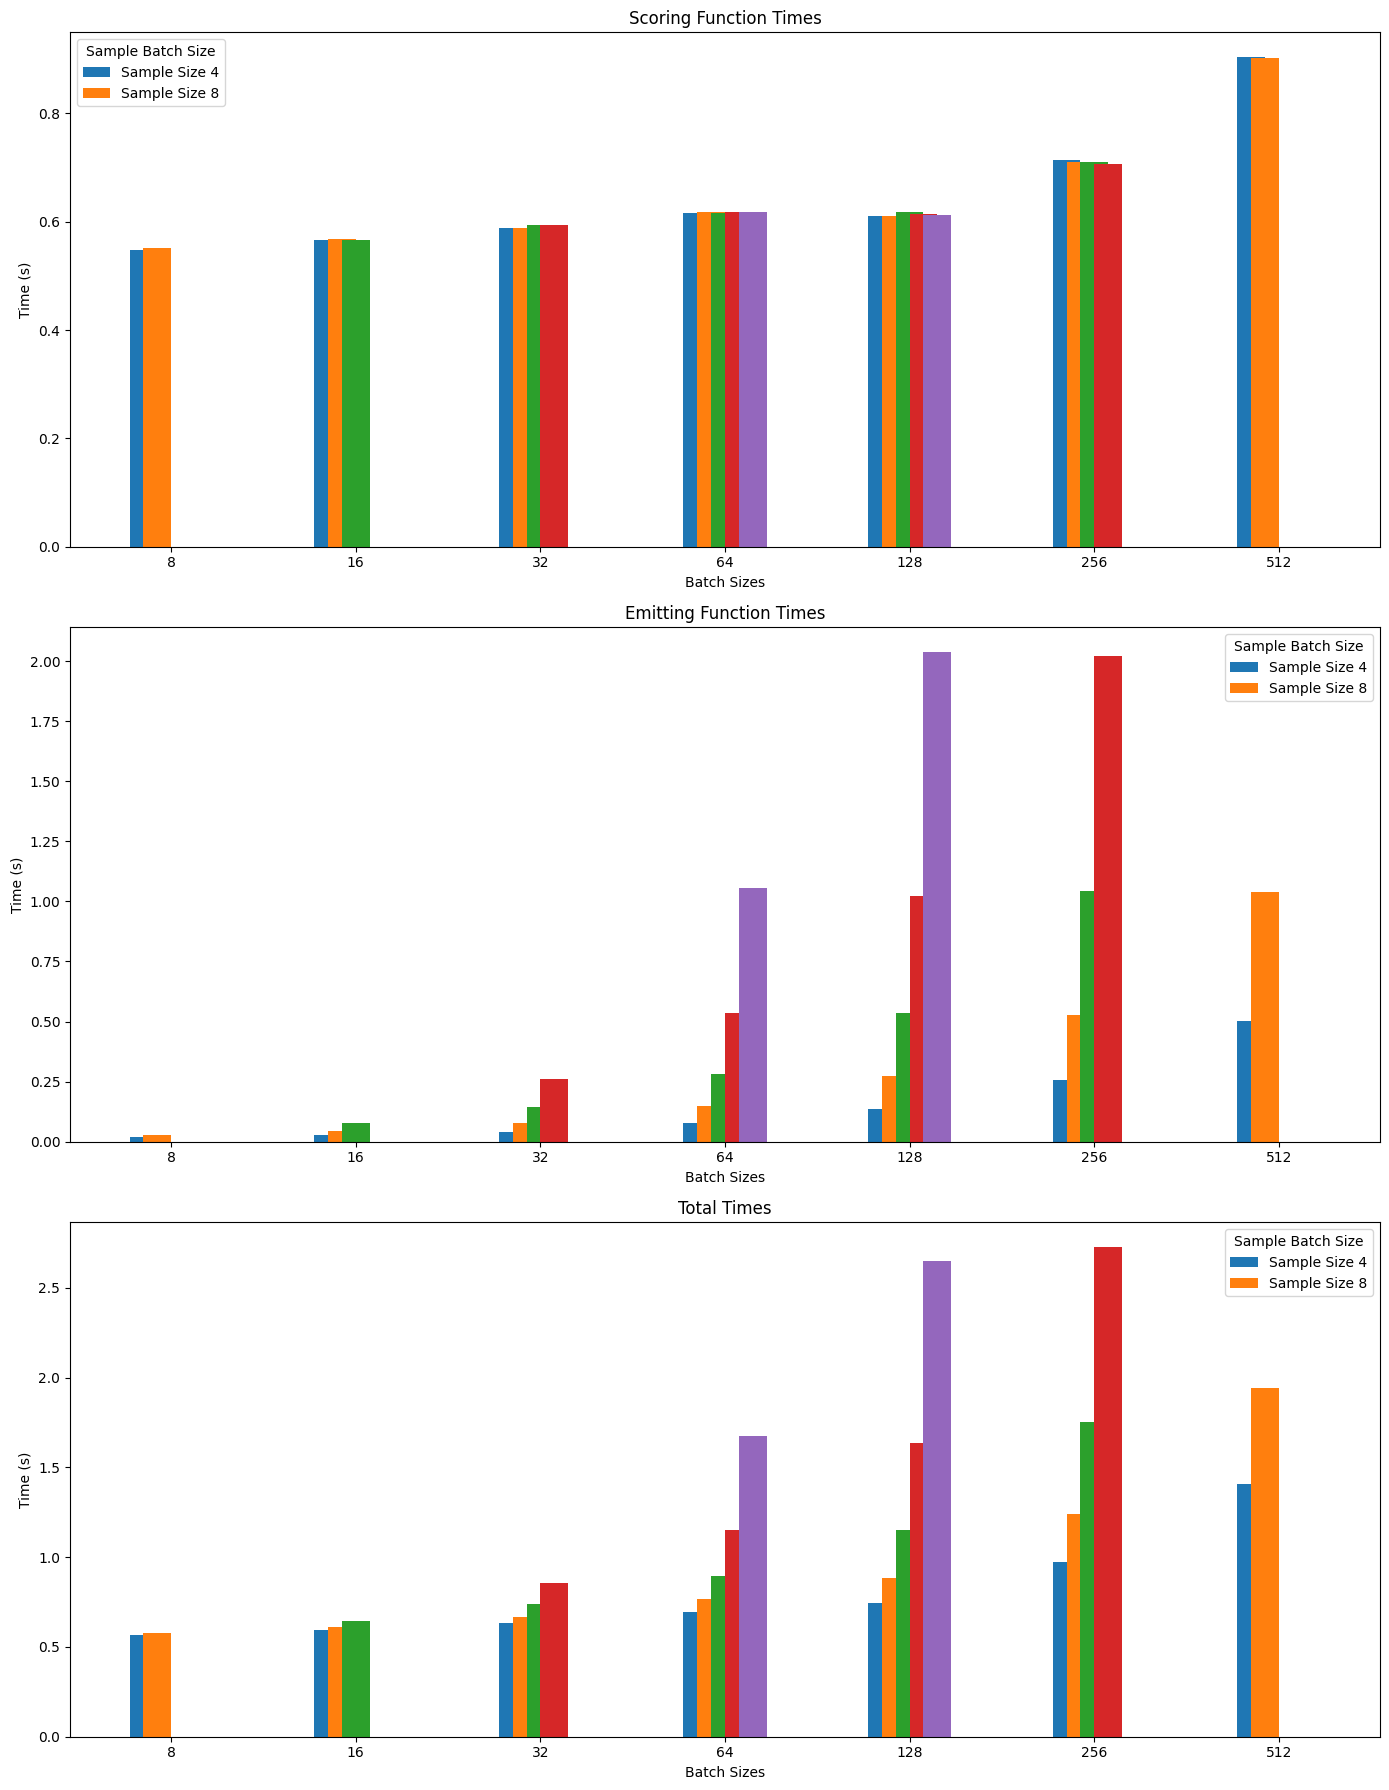

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Assume `results` is your dictionary


batch_sizes = list(results.keys())
sample_sizes_per_batch = [list(results[batch].keys()) for batch in batch_sizes]

# Number of sample sizes in each batch for plotting
n_samples = [len(samples) for samples in sample_sizes_per_batch]

# Data for plotting
score_fn_times = [[results[batch][sample]['score_fn'] for sample in results[batch]] for batch in batch_sizes]
emit_fn_times = [[results[batch][sample]['emit_fn'] for sample in results[batch]] for batch in batch_sizes]
total_times = [[results[batch][sample]['total_time'] for sample in results[batch]] for batch in batch_sizes]

fig, ax = plt.subplots(3, 1, figsize=(14, 18))  # 3 plots, one above the other

# x-axis positions for each group of bars
x = np.arange(len(batch_sizes))

# Width of a bar
bar_width = 0.15

# Adjust this offset depending on the number of sample sizes per batch size to prevent bar overlap
offsets = np.linspace(-bar_width*n_samples[0]/2, bar_width*n_samples[0]/2, num=max(n_samples))

# Plotting
for idx in range(max(n_samples)):
    ax[0].bar(x + offsets[idx], [group[idx] if idx < len(group) else 0 for group in score_fn_times], width=bar_width, label=f'Sample Size {sample_sizes_per_batch[0][idx]}' if idx < len(sample_sizes_per_batch[0]) else '')
    ax[1].bar(x + offsets[idx], [group[idx] if idx < len(group) else 0 for group in emit_fn_times], width=bar_width, label=f'Sample Size {sample_sizes_per_batch[0][idx]}' if idx < len(sample_sizes_per_batch[0]) else '')
    ax[2].bar(x + offsets[idx], [group[idx] if idx < len(group) else 0 for group in total_times], width=bar_width, label=f'Sample Size {sample_sizes_per_batch[0][idx]}' if idx < len(sample_sizes_per_batch[0]) else '')

# Adding titles and labels
ax[0].set_title('Scoring Function Times')
ax[1].set_title('Emitting Function Times')
ax[2].set_title('Total Times')

for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(batch_sizes)
    a.legend(title='Sample Batch Size')
    a.set_xlabel('Batch Sizes')
    a.set_ylabel('Time (s)')

plt.tight_layout()
plt.show()

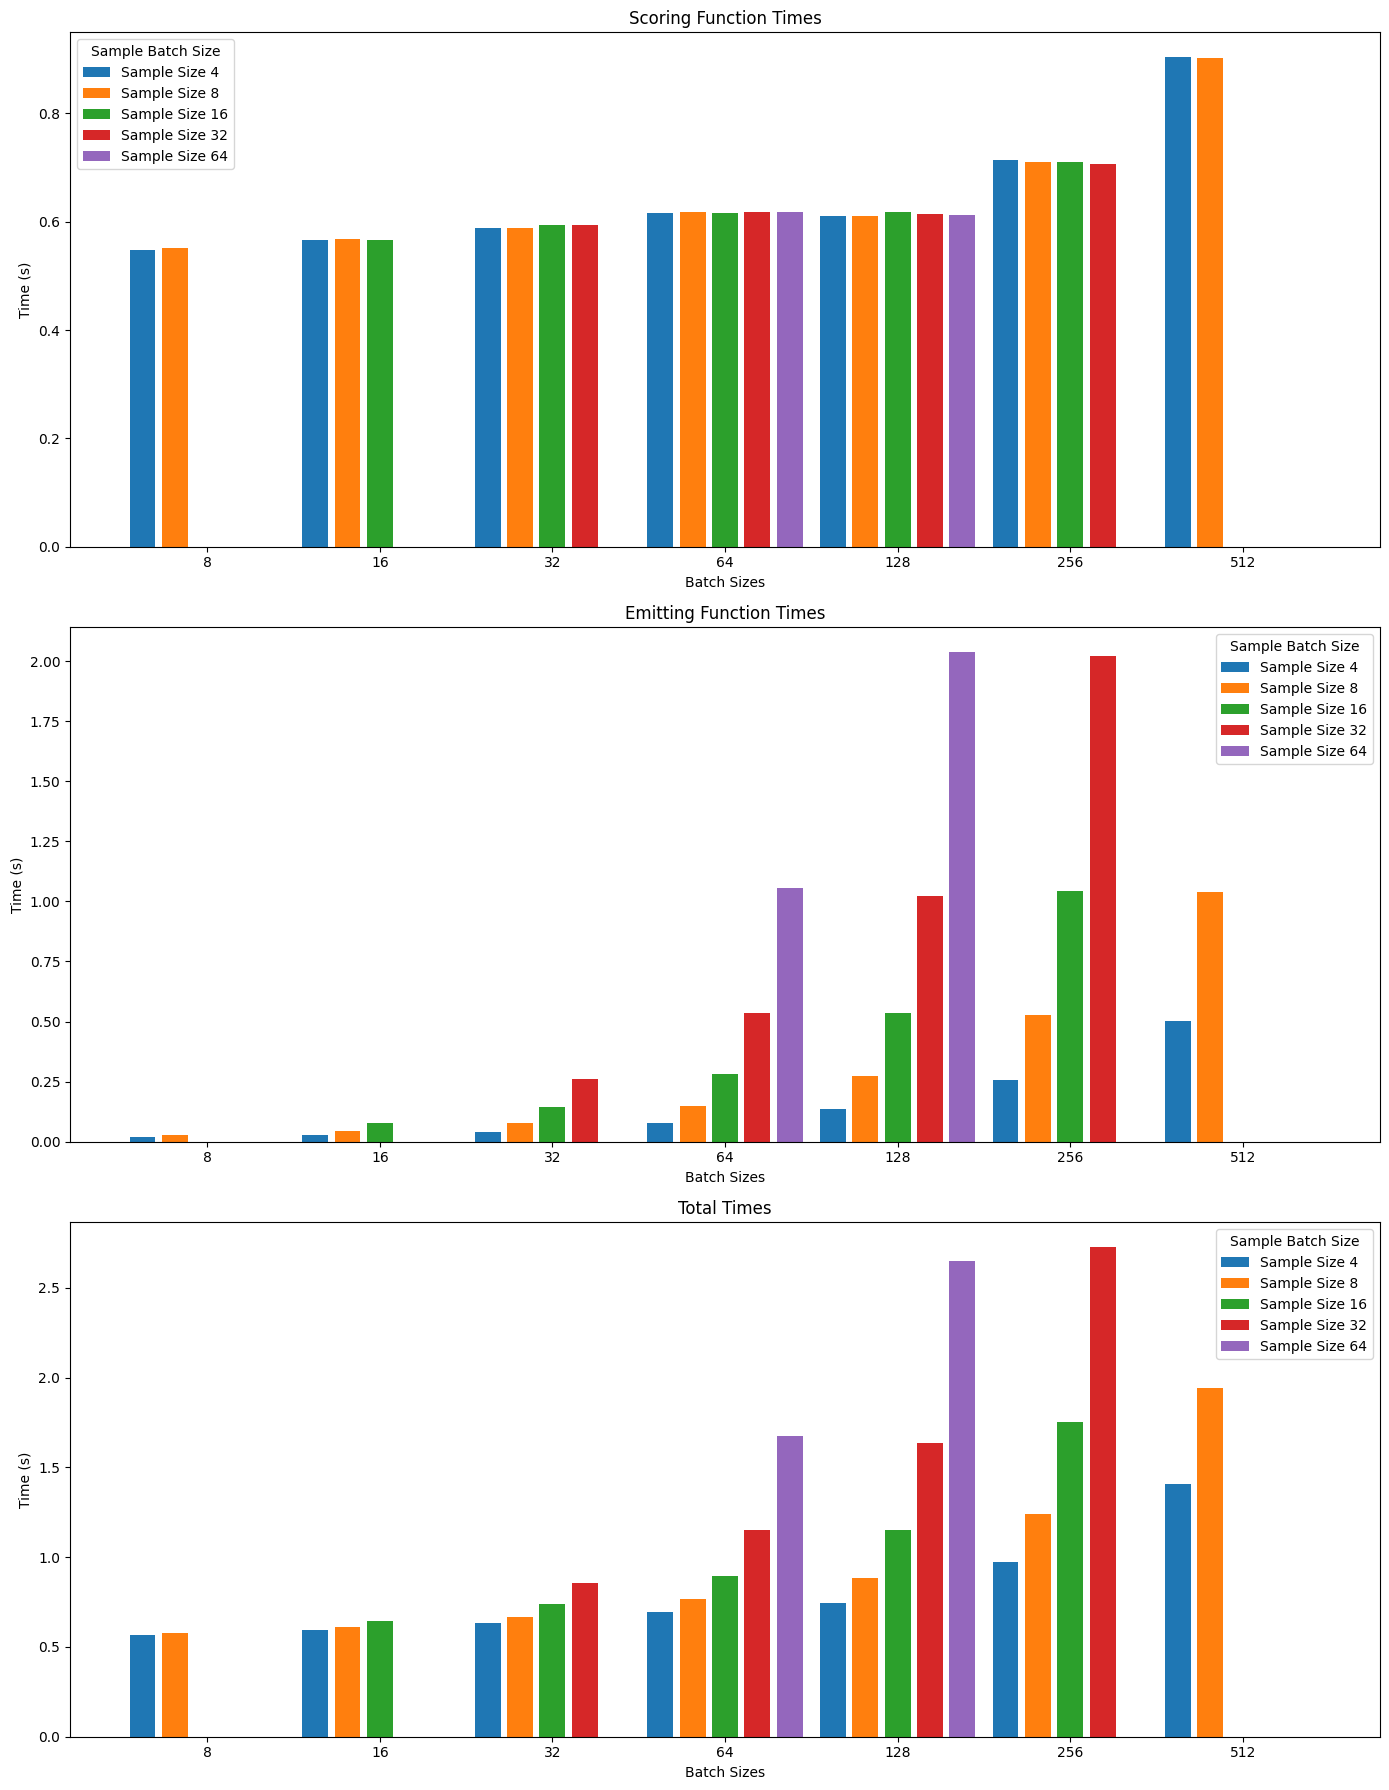

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `results` is already filled with your data.

batch_sizes = list(results.keys())
# Extract all unique sample sizes from each batch size for accurate legend labeling
sample_sizes_set = set()
for batch in results.values():
    sample_sizes_set.update(batch.keys())
sample_sizes_list = sorted(sample_sizes_set)

# Data for plotting
score_fn_times = []
emit_fn_times = []
total_times = []
for batch in batch_sizes:
    batch_score = []
    batch_emit = []
    batch_total = []
    for sample in sample_sizes_list:
        if sample in results[batch]:
            batch_score.append(results[batch][sample]['score_fn'])
            batch_emit.append(results[batch][sample]['emit_fn'])
            batch_total.append(results[batch][sample]['total_time'])
        else:
            # Append zero where data is not available to maintain alignment
            batch_score.append(0)
            batch_emit.append(0)
            batch_total.append(0)
    score_fn_times.append(batch_score)
    emit_fn_times.append(batch_emit)
    total_times.append(batch_total)

fig, ax = plt.subplots(3, 1, figsize=(14, 18))  # 3 plots, one above the other

# x-axis positions for each group of bars
x = np.arange(len(batch_sizes))

# Width of a bar
bar_width = 0.15
# Calculate offsets dynamically to center the groups
num_samples = len(sample_sizes_list)
offsets = np.linspace(-bar_width*num_samples/2, bar_width*num_samples/2, num=num_samples)

# Plotting
for idx, sample_size in enumerate(sample_sizes_list):
    ax[0].bar(x + offsets[idx], [group[idx] for group in score_fn_times], width=bar_width, label=f'Sample Size {sample_size}')
    ax[1].bar(x + offsets[idx], [group[idx] for group in emit_fn_times], width=bar_width, label=f'Sample Size {sample_size}')
    ax[2].bar(x + offsets[idx], [group[idx] for group in total_times], width=bar_width, label=f'Sample Size {sample_size}')

# Adding titles and labels
ax[0].set_title('Scoring Function Times')
ax[1].set_title('Emitting Function Times')
ax[2].set_title('Total Times')

for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(batch_sizes)
    a.legend(title='Sample Batch Size')
    a.set_xlabel('Batch Sizes')
    a.set_ylabel('Time (s)')

plt.tight_layout()
plt.show()

{8: {4: {'score_fn': 0.5479344944469631,
   'emit_fn': 0.018742638640105724,
   'total_time': 0.5666771330870688},
  8: {'score_fn': 0.5510504487901926,
   'emit_fn': 0.02665073247626424,
   'total_time': 0.5777011812664569}},
 16: {4: {'score_fn': 0.5664298803545534,
   'emit_fn': 0.027418756298720835,
   'total_time': 0.5938486366532743},
  8: {'score_fn': 0.5681056383065879,
   'emit_fn': 0.043314192071557046,
   'total_time': 0.611419830378145},
  16: {'score_fn': 0.5671369723975659,
   'emit_fn': 0.07749728113412857,
   'total_time': 0.6446342535316945}},
 32: {4: {'score_fn': 0.5890603879466653,
   'emit_fn': 0.04156291922554374,
   'total_time': 0.630623307172209},
  8: {'score_fn': 0.589206165727228,
   'emit_fn': 0.07690018350258469,
   'total_time': 0.6661063492298126},
  16: {'score_fn': 0.5943387716077269,
   'emit_fn': 0.1433646428398788,
   'total_time': 0.7377034144476057},
  32: {'score_fn': 0.5930616310797632,
   'emit_fn': 0.26279869824647906,
   'total_time': 0.85586

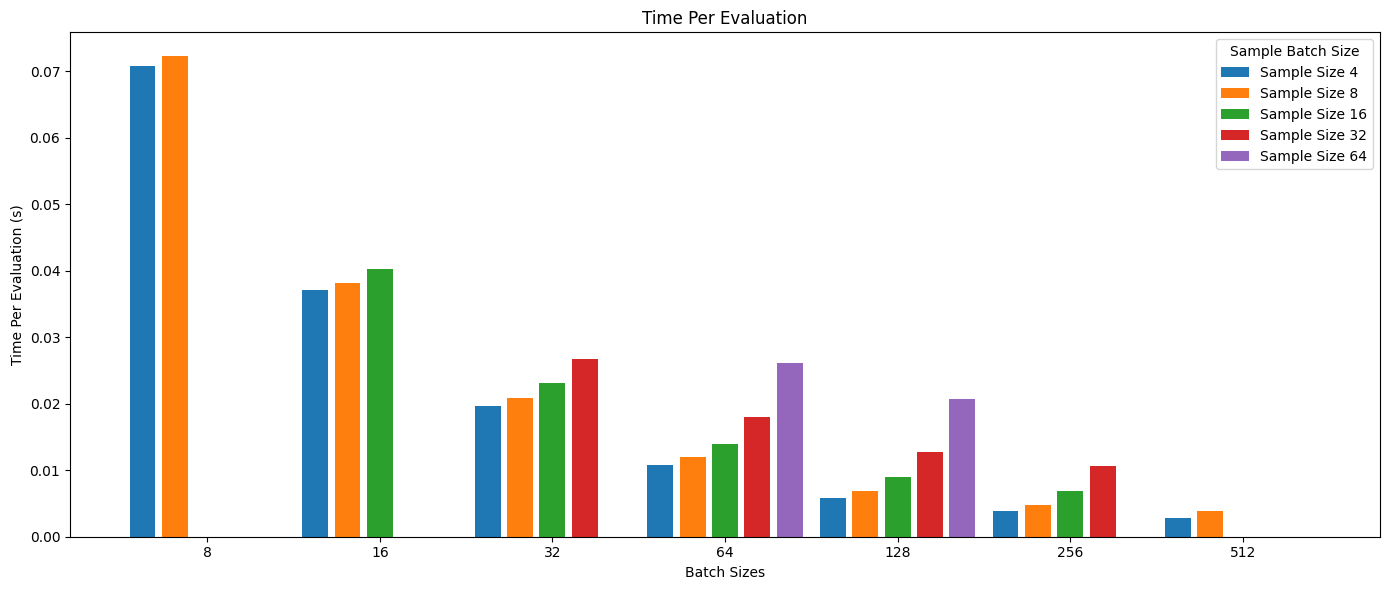

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' is defined as per the structure you confirmed

batch_sizes = list(results.keys())
# Extract all unique sample sizes from each batch size for accurate legend labeling
sample_sizes_set = set()
for batch in results.values():
    sample_sizes_set.update(batch.keys())
sample_sizes_list = sorted(sample_sizes_set)

# Prepare data for plotting
time_per_evaluation = []
for batch in batch_sizes:
    batch_times = []
    for sample in sample_sizes_list:
        if sample in results[batch]:
            total_time = results[batch][sample]['total_time']
            # Calculate time per evaluation by dividing total time by the batch size
            time_per_eval = total_time / batch
            batch_times.append(time_per_eval)
        else:
            # Append zero where data is not available to maintain alignment
            batch_times.append(0)
    time_per_evaluation.append(batch_times)

fig, ax = plt.subplots(figsize=(14, 6))  # One plot

# x-axis positions for each group of bars
x = np.arange(len(batch_sizes))

# Width of a bar
bar_width = 0.15
# Calculate offsets dynamically to center the groups
num_samples = len(sample_sizes_list)
offsets = np.linspace(-bar_width*num_samples/2, bar_width*num_samples/2, num=num_samples)

# Plotting
for idx, sample_size in enumerate(sample_sizes_list):
    ax.bar(x + offsets[idx], [group[idx] for group in time_per_evaluation], width=bar_width, label=f'Sample Size {sample_size}')

# Adding titles and labels
ax.set_title('Time Per Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(batch_sizes)
ax.legend(title='Sample Batch Size')
ax.set_xlabel('Batch Sizes')
ax.set_ylabel('Time Per Evaluation (s)')

plt.tight_layout()
plt.show()